### Antoine EDY
# Natural Language Processing (COMM061) - Coursework

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
import nltk
from torch.utils.tensorboard import SummaryWriter

In [2]:
dataset = load_dataset("surrey-nlp/PLOD-CW")

In [3]:
TEXT2ID = {
    "B-O": 0,
    "B-AC": 1,
    "PAD": 2,
    "B-LF": 3,
    "I-LF": 4,
}
ID2TEXT = {v: k for k, v in TEXT2ID.items()}

print(f"TEXT2ID: {TEXT2ID}\nID2TEXT: {ID2TEXT}\n")

def preprocess(df):
    df = df.drop(columns=['pos_tags'])
    df = df.rename(columns={"ner_tags": "labels"})
    df["ids"] = df["labels"].apply(lambda x: [TEXT2ID[i] for i in x])
    df["sentences"] = df["tokens"].apply(lambda x: " ".join(x))

    return df


train_dataset = preprocess(pd.DataFrame(dataset['train']))
test_dataset = preprocess(pd.DataFrame(dataset['test']))
val_dataset = preprocess(pd.DataFrame(dataset['validation']))

train_dataset.info()


# Here the exploration to add at the end of the work.

TEXT2ID: {'B-O': 0, 'B-AC': 1, 'PAD': 2, 'B-LF': 3, 'I-LF': 4}
ID2TEXT: {0: 'B-O', 1: 'B-AC', 2: 'PAD', 3: 'B-LF', 4: 'I-LF'}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tokens     1072 non-null   object
 1   labels     1072 non-null   object
 2   ids        1072 non-null   object
 3   sentences  1072 non-null   object
dtypes: object(4)
memory usage: 33.6+ KB


In [4]:
train_dataset.head()

,tokens,labels,ids,sentences
0,"[For, this, purpose, the, Gothenburg, Young, P...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I...","[0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 1, 0, 0, 0, 0]",For this purpose the Gothenburg Young Persons ...
1,"[The, following, physiological, traits, were, ...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF...","[0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 1, 0, 0, 0, 0, ...",The following physiological traits were measur...
2,"[Minor, H, antigen, alloimmune, responses, rea...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, ...",Minor H antigen alloimmune responses readily o...
3,"[EPI, =, Echo, planar, imaging, .]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]","[1, 0, 3, 4, 4, 0]",EPI = Echo planar imaging .
4,"[Furthermore, ,, eNOS, -, derived, NO, S, -, n...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Furthermore , eNOS - derived NO S - nitrosylat..."


In [5]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

1072
126
153


In [6]:
train_dataset.head()

,tokens,labels,ids,sentences
0,"[For, this, purpose, the, Gothenburg, Young, P...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I...","[0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 1, 0, 0, 0, 0]",For this purpose the Gothenburg Young Persons ...
1,"[The, following, physiological, traits, were, ...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF...","[0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 1, 0, 0, 0, 0, ...",The following physiological traits were measur...
2,"[Minor, H, antigen, alloimmune, responses, rea...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, ...",Minor H antigen alloimmune responses readily o...
3,"[EPI, =, Echo, planar, imaging, .]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]","[1, 0, 3, 4, 4, 0]",EPI = Echo planar imaging .
4,"[Furthermore, ,, eNOS, -, derived, NO, S, -, n...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Furthermore , eNOS - derived NO S - nitrosylat..."


In [7]:
from torchtext.data import Field, Dataset, Example

text_field = Field(sequential=True, tokenize=lambda x:x, include_lengths=True) # Default behaviour is to tokenize by splitting
label_field = Field(sequential=True, tokenize=lambda x:x, is_target=True)

fields = {
    'sentences': ('text', text_field),
    'ids': ('label', label_field)
}

def read_data(df):
    examples = []
    fields = {'sentence_labels': ('labels', label_field),
              'sentence_tokens': ('text', text_field)}
    
    for i in range(len(df)):
        tokens = df['tokens'][i]
        labels = df['labels'][i]
        
        e = Example.fromdict({"sentence_labels": labels, "sentence_tokens": tokens},
                             fields=fields)
        examples.append(e)
    
    return Dataset(examples, fields=[('labels', label_field), ('text', text_field)])


train_data = read_data(train_dataset)
val_data = read_data(val_dataset)
test_data = read_data(test_dataset)

print(train_data.fields)
print(train_data[0].text)
print(train_data[0].labels)

print("Train:", len(train_data))
print("Dev:", len(val_data))
print("Test:", len(test_data))

{'labels': <torchtext.data.field.Field object at 0x1749dbdf0>, 'text': <torchtext.data.field.Field object at 0x107b65ff0>}
['For', 'this', 'purpose', 'the', 'Gothenburg', 'Young', 'Persons', 'Empowerment', 'Scale', '(', 'GYPES', ')', 'was', 'developed', '.']
['B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-O', 'B-O', 'B-O', 'B-O']
Train: 1072
Dev: 126
Test: 153


In [8]:
VOCAB_SIZE = 20000

text_field.build_vocab(train_data, max_size=VOCAB_SIZE)
label_field.build_vocab(train_data)

In [9]:
from torchtext.data import BucketIterator

BATCH_SIZE = 32
train_iter = BucketIterator(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, 
                            sort_key=lambda x: len(x.text), sort_within_batch=True)
val_iter = BucketIterator(dataset=val_data, batch_size=BATCH_SIZE, 
                          sort_key=lambda x: len(x.text), sort_within_batch=True)
test_iter = BucketIterator(dataset=test_data, batch_size=BATCH_SIZE, 
                           sort_key=lambda x: len(x.text), sort_within_batch=True)

In [10]:
import random
import os
import numpy as np

from transformers import BertModel

model = BertModel.from_pretrained("bert-base-uncased")
embedding_matrix = torch.from_numpy(model.embeddings.word_embeddings.weight.detach().numpy())
embedding_matrix.shape

torch.Size([30522, 768])

In [11]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BiLSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, embeddings=None):
        super(BiLSTMTagger, self).__init__()
        
        # 1. Embedding Layer
        if embeddings is None:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embeddings = nn.Embedding.from_pretrained(embeddings)
        
        # 2. LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=1)
        
        # 3. Optional dropout layer
        self.dropout_layer = nn.Dropout(p=0.5)

        # 4. Dense Layer
        self.hidden2tag = nn.Linear(2*hidden_dim, output_size)
        
    def forward(self, batch_text, batch_lengths):

        embeddings = self.embeddings(batch_text)
        
        packed_seqs = pack_padded_sequence(embeddings, batch_lengths)
        lstm_output, _ = self.lstm(packed_seqs)
        lstm_output, _ = pad_packed_sequence(lstm_output)
        lstm_output = self.dropout_layer(lstm_output)
        
        logits = self.hidden2tag(lstm_output)
        return logits

In [12]:
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, classification_report

def remove_predictions_for_masked_items(predicted_labels, correct_labels): 

    predicted_labels_without_mask = []
    correct_labels_without_mask = []
        
    for p, c in zip(predicted_labels, correct_labels):
        if c > 1:
            predicted_labels_without_mask.append(p)
            correct_labels_without_mask.append(c)
            
    return predicted_labels_without_mask, correct_labels_without_mask

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = len(label_field.vocab)
print(f"Number of classes: {NUM_CLASSES}: {label_field.vocab.itos}")

def train(model, train_iter, dev_iter, batch_size, max_epochs, num_batches, patience, output_path):
    writer = SummaryWriter(comment = f'bert')
    criterion = nn.CrossEntropyLoss(ignore_index=1)  # we mask the <pad> labels
    optimizer = optim.Adam(model.parameters())

    train_f_score_history = []
    dev_f_score_history = []
    no_improvement = 0
    for epoch in range(max_epochs):

        total_loss = 0
        predictions, correct = [], []
        for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):
            optimizer.zero_grad()
            
            text_length, cur_batch_size = batch.text[0].shape
            
            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size*text_length)
            
            loss = criterion(pred, gold)
            
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            _, pred_indices = torch.max(pred, 1)
            
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        train_scores = precision_recall_fscore_support(correct, predictions, average="micro")
        train_f_score_history.append(train_scores[2])
            
        print("Total training loss:", total_loss)
        print("Training performance:", train_scores)

        #tensorboard
        writer.add_scalar('train/loss', total_loss, epoch)
        writer.add_scalar('train/precision', train_scores[2], epoch)
        
        total_loss = 0
        predictions, correct = [], []
        for batch in dev_iter:

            text_length, cur_batch_size = batch.text[0].shape

            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size * text_length)
            loss = criterion(pred, gold)
            total_loss += loss.item()

            _, pred_indices = torch.max(pred, 1)
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        dev_scores = precision_recall_fscore_support(correct, predictions, average="micro")
            
        print("Total development loss:", total_loss)
        print("Development performance:", dev_scores)

        writer.add_scalar('val/loss', total_loss, epoch)
        writer.add_scalar('val/precision', dev_scores[2], epoch)
        
        dev_f = dev_scores[2]
        if len(dev_f_score_history) > patience and dev_f < max(dev_f_score_history):
            no_improvement += 1

        elif len(dev_f_score_history) == 0 or dev_f > max(dev_f_score_history):
            print("Saving model.")
            torch.save(model, output_path)
            no_improvement = 0
            
        if no_improvement > patience:
            print("Development F-score does not improve anymore. Stop training.")
            dev_f_score_history.append(dev_f)
            break
            
        dev_f_score_history.append(dev_f)
        
    return train_f_score_history, dev_f_score_history

Number of classes: 6: ['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF']


In [13]:
def test(model, test_iter, batch_size, labels, target_names): 
    
    total_loss = 0
    predictions, correct = [], []
    for batch in test_iter:

        text_length, cur_batch_size = batch.text[0].shape

        pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
        gold = batch.labels.to(device).view(cur_batch_size * text_length)

        _, pred_indices = torch.max(pred, 1)
        predicted_labels = list(pred_indices.cpu().numpy())
        correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())

        predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, correct_labels)

        predictions += predicted_labels
        correct += correct_labels
    
    print(classification_report(correct, predictions, labels=labels, target_names=target_names))

In [14]:
import math

EMBEDDING_DIM = 768
HIDDEN_DIM = 256
NUM_CLASSES = len(label_field.vocab)
print(f"Number of classes: {NUM_CLASSES} : {label_field.vocab.itos}")
MAX_EPOCHS = 50
PATIENCE = 50
OUTPUT_PATH = "model_saves/bilstmtagger"
num_batches = math.ceil(len(train_data) / BATCH_SIZE)

tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES, embeddings=embedding_matrix)  # embeddings
# tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES)  # no embeddings

train_f, dev_f = train(tagger.to(device), train_iter, val_iter, BATCH_SIZE, MAX_EPOCHS, 
                       num_batches, PATIENCE, OUTPUT_PATH)

Number of classes: 6 : ['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF']


Epoch 0: 100%|██████████| 34/34 [00:05<00:00,  6.73it/s]


Total training loss: 28.395501792430878
Training performance: (0.8129, 0.8129, 0.8129, None)
Total development loss: 2.529080808162689
Development performance: (0.8522, 0.8522, 0.8522, None)
Saving model.


Epoch 1: 100%|██████████| 34/34 [00:04<00:00,  6.85it/s]


Total training loss: 23.10516306757927
Training performance: (0.824275, 0.824275, 0.824275, None)
Total development loss: 2.4097476601600647
Development performance: (0.8522, 0.8522, 0.8522, None)


Epoch 2: 100%|██████████| 34/34 [00:05<00:00,  6.21it/s]


Total training loss: 22.27322566509247
Training performance: (0.8242, 0.8242, 0.8242, None)
Total development loss: 2.4036123156547546
Development performance: (0.8516, 0.8516, 0.8516, None)


Epoch 3: 100%|██████████| 34/34 [00:05<00:00,  6.79it/s]


Total training loss: 21.799479365348816
Training performance: (0.822575, 0.822575, 0.822575, None)
Total development loss: 2.4342694878578186
Development performance: (0.8492, 0.8492, 0.8492, None)


Epoch 4: 100%|██████████| 34/34 [00:05<00:00,  6.70it/s]


Total training loss: 21.33254450559616
Training performance: (0.822675, 0.822675, 0.822675, None)
Total development loss: 2.391244053840637
Development performance: (0.8514, 0.8514, 0.8514, None)


Epoch 5: 100%|██████████| 34/34 [00:04<00:00,  7.07it/s]


Total training loss: 20.863177716732025
Training performance: (0.82325, 0.82325, 0.82325, None)
Total development loss: 2.3612738251686096
Development performance: (0.8518, 0.8518, 0.8518, None)


Epoch 6: 100%|██████████| 34/34 [00:04<00:00,  7.11it/s]


Total training loss: 20.38987225294113
Training performance: (0.823425, 0.823425, 0.823425, None)
Total development loss: 2.3544926047325134
Development performance: (0.85, 0.85, 0.85, None)


Epoch 7: 100%|██████████| 34/34 [00:04<00:00,  8.04it/s]


Total training loss: 19.712586373090744
Training performance: (0.8255, 0.8255, 0.8255, None)
Total development loss: 2.246247798204422
Development performance: (0.8532, 0.8532, 0.8532, None)
Saving model.


Epoch 8: 100%|██████████| 34/34 [00:04<00:00,  7.63it/s]


Total training loss: 17.876057475805283
Training performance: (0.833925, 0.833925, 0.833925, None)
Total development loss: 1.9463771879673004
Development performance: (0.8622, 0.8622, 0.8622, None)
Saving model.


Epoch 9: 100%|██████████| 34/34 [00:04<00:00,  7.27it/s]


Total training loss: 15.63317859172821
Training performance: (0.8502, 0.8502, 0.8502, None)
Total development loss: 1.7977416813373566
Development performance: (0.8684, 0.8684, 0.8684, None)
Saving model.


Epoch 10: 100%|██████████| 34/34 [00:04<00:00,  7.22it/s]


Total training loss: 14.398287296295166
Training performance: (0.8562, 0.8562, 0.8562, None)
Total development loss: 1.7957206666469574
Development performance: (0.869, 0.869, 0.869, None)
Saving model.


Epoch 11: 100%|██████████| 34/34 [00:04<00:00,  6.92it/s]


Total training loss: 13.622053295373917
Training performance: (0.86245, 0.86245, 0.86245, None)
Total development loss: 1.6526947021484375
Development performance: (0.8742, 0.8742, 0.8742, None)
Saving model.


Epoch 12: 100%|██████████| 34/34 [00:04<00:00,  7.98it/s]


Total training loss: 12.744464039802551
Training performance: (0.871025, 0.871025, 0.871025, None)
Total development loss: 1.696660429239273
Development performance: (0.8694, 0.8694, 0.8694, None)


Epoch 13: 100%|██████████| 34/34 [00:04<00:00,  6.82it/s]


Total training loss: 12.09931194782257
Training performance: (0.876875, 0.876875, 0.876875, None)
Total development loss: 1.6021509766578674
Development performance: (0.876, 0.876, 0.876, None)
Saving model.


Epoch 14: 100%|██████████| 34/34 [00:05<00:00,  5.68it/s]


Total training loss: 11.42131194472313
Training performance: (0.884, 0.884, 0.884, None)
Total development loss: 1.6104713082313538
Development performance: (0.881, 0.881, 0.881, None)
Saving model.


Epoch 15: 100%|██████████| 34/34 [00:05<00:00,  5.73it/s]


Total training loss: 11.127553224563599
Training performance: (0.88725, 0.88725, 0.88725, None)
Total development loss: 1.6180641055107117
Development performance: (0.877, 0.877, 0.877, None)


Epoch 16: 100%|██████████| 34/34 [00:04<00:00,  7.55it/s]


Total training loss: 10.420145019888878
Training performance: (0.89365, 0.89365, 0.89365, None)
Total development loss: 1.66341894865036
Development performance: (0.8768, 0.8768, 0.8768, None)


Epoch 17: 100%|██████████| 34/34 [00:04<00:00,  6.81it/s]


Total training loss: 10.191980585455894
Training performance: (0.8952, 0.8952, 0.8952, None)
Total development loss: 1.5944483280181885
Development performance: (0.8788, 0.8788, 0.8788, None)


Epoch 18: 100%|██████████| 34/34 [00:04<00:00,  7.00it/s]


Total training loss: 9.825932532548904
Training performance: (0.897725, 0.897725, 0.897725, None)
Total development loss: 1.5476235747337341
Development performance: (0.8784, 0.8784, 0.8784, None)


Epoch 19: 100%|██████████| 34/34 [00:04<00:00,  6.90it/s]


Total training loss: 9.350981175899506
Training performance: (0.902, 0.902, 0.902, None)
Total development loss: 1.6309751570224762
Development performance: (0.8786, 0.8786, 0.8786, None)


Epoch 20: 100%|██████████| 34/34 [00:05<00:00,  6.41it/s]


Total training loss: 8.654620587825775
Training performance: (0.90805, 0.90805, 0.90805, None)
Total development loss: 1.6011192798614502
Development performance: (0.8856, 0.8856, 0.8856, None)
Saving model.


Epoch 21: 100%|██████████| 34/34 [00:05<00:00,  6.24it/s]


Total training loss: 8.1431245803833
Training performance: (0.915625, 0.915625, 0.915625, None)
Total development loss: 1.6659129858016968
Development performance: (0.8808, 0.8808, 0.8808, None)


Epoch 22: 100%|██████████| 34/34 [00:05<00:00,  6.32it/s]


Total training loss: 7.832135006785393
Training performance: (0.9165, 0.9165, 0.9165, None)
Total development loss: 1.6862821578979492
Development performance: (0.8842, 0.8842, 0.8842, None)


Epoch 23: 100%|██████████| 34/34 [00:05<00:00,  6.02it/s]


Total training loss: 7.647342219948769
Training performance: (0.9215, 0.9215, 0.9215, None)
Total development loss: 1.5875338315963745
Development performance: (0.8844, 0.8844, 0.8844, None)


Epoch 24: 100%|██████████| 34/34 [00:05<00:00,  6.33it/s]


Total training loss: 7.1625838577747345
Training performance: (0.92485, 0.92485, 0.92485, None)
Total development loss: 1.6132963597774506
Development performance: (0.8812, 0.8812, 0.8812, None)


Epoch 25: 100%|██████████| 34/34 [00:05<00:00,  5.79it/s]


Total training loss: 6.9465857073664665
Training performance: (0.925625, 0.925625, 0.925625, None)
Total development loss: 1.70091912150383
Development performance: (0.877, 0.877, 0.877, None)


Epoch 26: 100%|██████████| 34/34 [00:06<00:00,  5.63it/s]


Total training loss: 6.555132046341896
Training performance: (0.9323, 0.9323, 0.9323, None)
Total development loss: 1.6838635206222534
Development performance: (0.8836, 0.8836, 0.8836, None)


Epoch 27: 100%|██████████| 34/34 [00:05<00:00,  6.19it/s]


Total training loss: 6.329769462347031
Training performance: (0.93365, 0.93365, 0.93365, None)
Total development loss: 1.855551689863205
Development performance: (0.878, 0.878, 0.878, None)


Epoch 28: 100%|██████████| 34/34 [00:05<00:00,  5.89it/s]


Total training loss: 6.274551160633564
Training performance: (0.932125, 0.932125, 0.932125, None)
Total development loss: 1.7349734902381897
Development performance: (0.8854, 0.8854, 0.8854, None)


Epoch 29: 100%|██████████| 34/34 [00:05<00:00,  6.02it/s]


Total training loss: 5.992686897516251
Training performance: (0.937125, 0.937125, 0.937125, None)
Total development loss: 1.7489387094974518
Development performance: (0.8806, 0.8806, 0.8806, None)


Epoch 30: 100%|██████████| 34/34 [00:05<00:00,  6.29it/s]


Total training loss: 5.756801053881645
Training performance: (0.939225, 0.939225, 0.939225, None)
Total development loss: 1.7574901282787323
Development performance: (0.8802, 0.8802, 0.8802, None)


Epoch 31: 100%|██████████| 34/34 [00:05<00:00,  6.38it/s]


Total training loss: 5.562561884522438
Training performance: (0.9417, 0.9417, 0.9417, None)
Total development loss: 1.7341721951961517
Development performance: (0.881, 0.881, 0.881, None)


Epoch 32: 100%|██████████| 34/34 [00:06<00:00,  5.58it/s]


Total training loss: 4.902255654335022
Training performance: (0.9471, 0.9471, 0.9471, None)
Total development loss: 1.8453086912631989
Development performance: (0.8784, 0.8784, 0.8784, None)


Epoch 33: 100%|██████████| 34/34 [00:05<00:00,  6.50it/s]


Total training loss: 4.707001775503159
Training performance: (0.950425, 0.950425, 0.950425, None)
Total development loss: 1.9409618079662323
Development performance: (0.8854, 0.8854, 0.8854, None)


Epoch 34: 100%|██████████| 34/34 [00:05<00:00,  6.60it/s]


Total training loss: 4.457923762500286
Training performance: (0.952325, 0.952325, 0.952325, None)
Total development loss: 1.8884775042533875
Development performance: (0.8864, 0.8864, 0.8864, None)
Saving model.


Epoch 35: 100%|██████████| 34/34 [00:05<00:00,  6.14it/s]


Total training loss: 4.5565989054739475
Training performance: (0.95075, 0.95075, 0.95075, None)
Total development loss: 2.014961898326874
Development performance: (0.8788, 0.8788, 0.8788, None)


Epoch 36: 100%|██████████| 34/34 [00:05<00:00,  6.34it/s]


Total training loss: 4.518015801906586
Training performance: (0.951625, 0.951625, 0.951625, None)
Total development loss: 1.9358603060245514
Development performance: (0.8834, 0.8834, 0.8834, None)


Epoch 37: 100%|██████████| 34/34 [00:05<00:00,  6.20it/s]


Total training loss: 4.08206806704402
Training performance: (0.9561, 0.9561, 0.9561, None)
Total development loss: 1.9643858969211578
Development performance: (0.8808, 0.8808, 0.8808, None)


Epoch 38: 100%|██████████| 34/34 [00:05<00:00,  5.67it/s]


Total training loss: 3.8307409174740314
Training performance: (0.958, 0.958, 0.958, None)
Total development loss: 2.081803560256958
Development performance: (0.8716, 0.8716, 0.8716, None)


Epoch 39: 100%|██████████| 34/34 [00:05<00:00,  6.10it/s]


Total training loss: 3.763358388096094
Training performance: (0.9596, 0.9596, 0.9596, None)
Total development loss: 2.028197228908539
Development performance: (0.882, 0.882, 0.882, None)


Epoch 40: 100%|██████████| 34/34 [00:05<00:00,  6.50it/s]


Total training loss: 3.561906933784485
Training performance: (0.961725, 0.961725, 0.961725, None)
Total development loss: 1.938565343618393
Development performance: (0.8822, 0.8822, 0.8822, None)


Epoch 41: 100%|██████████| 34/34 [00:05<00:00,  6.44it/s]


Total training loss: 3.4037532955408096
Training performance: (0.9632, 0.9632, 0.9632, None)
Total development loss: 2.181005209684372
Development performance: (0.8794, 0.8794, 0.8794, None)


Epoch 42: 100%|██████████| 34/34 [00:05<00:00,  6.11it/s]


Total training loss: 3.2959253266453743
Training performance: (0.963775, 0.963775, 0.963775, None)
Total development loss: 2.2989216446876526
Development performance: (0.8774, 0.8774, 0.8774, None)


Epoch 43: 100%|██████████| 34/34 [00:05<00:00,  6.15it/s]


Total training loss: 3.345027692615986
Training performance: (0.9632, 0.9632, 0.9632, None)
Total development loss: 2.1856013238430023
Development performance: (0.8746, 0.8746, 0.8746, None)


Epoch 44: 100%|██████████| 34/34 [00:05<00:00,  6.06it/s]


Total training loss: 2.964886363595724
Training performance: (0.968725, 0.968725, 0.968725, None)
Total development loss: 2.489564299583435
Development performance: (0.8798, 0.8798, 0.8798, None)


Epoch 45: 100%|██████████| 34/34 [00:05<00:00,  5.89it/s]


Total training loss: 3.1341829150915146
Training performance: (0.96395, 0.96395, 0.96395, None)
Total development loss: 2.1909753680229187
Development performance: (0.8736, 0.8736, 0.8736, None)


Epoch 46: 100%|██████████| 34/34 [00:05<00:00,  5.85it/s]


Total training loss: 2.6780650056898594
Training performance: (0.969475, 0.969475, 0.969475, None)
Total development loss: 2.257370710372925
Development performance: (0.8768, 0.8768, 0.8768, None)


Epoch 47: 100%|██████████| 34/34 [00:05<00:00,  5.93it/s]


Total training loss: 2.5722320582717657
Training performance: (0.971375, 0.971375, 0.971375, None)
Total development loss: 2.257574588060379
Development performance: (0.8736, 0.8736, 0.8736, None)


Epoch 48: 100%|██████████| 34/34 [00:06<00:00,  5.56it/s]


Total training loss: 2.5712859388440847
Training performance: (0.970375, 0.970375, 0.970375, None)
Total development loss: 2.418140232563019
Development performance: (0.875, 0.875, 0.875, None)


Epoch 49: 100%|██████████| 34/34 [00:06<00:00,  5.42it/s]


Total training loss: 2.2290460485965014
Training performance: (0.974875, 0.974875, 0.974875, None)
Total development loss: 2.659114420413971
Development performance: (0.8762, 0.8762, 0.8762, None)


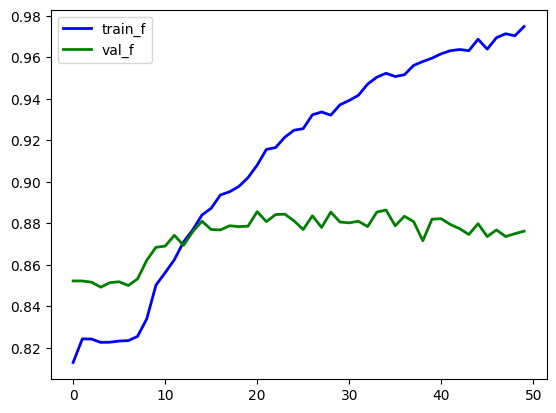

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

# Data
df = pd.DataFrame({'epochs': range(0,len(train_f)), 
                  'train_f': train_f, 
                   'val_f': dev_f})
 
# multiple line plot
plt.plot('epochs', 'train_f', data=df, color='blue', linewidth=2)
plt.plot('epochs', 'val_f', data=df, color='green', linewidth=2)
plt.legend()
plt.show()


In [16]:
%load_ext tensorboard

In [17]:
tagger = torch.load(OUTPUT_PATH)
tagger.eval()

BiLSTMTagger(
  (embeddings): Embedding(30522, 768)
  (lstm): LSTM(768, 256, bidirectional=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (hidden2tag): Linear(in_features=512, out_features=6, bias=True)
)

In [18]:
labels = label_field.vocab.itos[2:]
labels = sorted(labels, key=lambda x: x.split("-")[-1])
label_idxs = [label_field.vocab.stoi[l] for l in labels]

test(tagger, test_iter, BATCH_SIZE, labels = label_idxs, target_names = labels)

              precision    recall  f1-score   support

        B-AC       0.66      0.33      0.44       270
        I-LF       0.55      0.35      0.43       288
        B-LF       0.37      0.24      0.29       150
         B-O       0.91      0.97      0.93      4292

    accuracy                           0.88      5000
   macro avg       0.62      0.47      0.52      5000
weighted avg       0.86      0.88      0.86      5000



In [19]:
from colorama import Back, Style

def vizu(words, output, truth):
    if isinstance(output, torch.Tensor):
        output = output.squeeze().tolist()
    col = {0: Back.BLACK, 1: Back.RED, 2: Back.GREEN, 3: Back.BLUE, 4: Back.MAGENTA}
    colors1 = [col[i] for i in output]
    colors2 = [col[i] for i in truth]
    words = [word.replace("Ġ", "") for word in words]
    print(Style.RESET_ALL + "Output:")
    for i, word in enumerate(words):
        print(colors1[i] + word, end=" ")
    print(Style.RESET_ALL + "\nTruth:")
    for i, word in enumerate(words):
        print(colors2[i] + word, end=" ")